In [8]:
import numpy as np
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [9]:
train_dataset = MNIST(download=True, root='data', train=True, transform=ToTensor())
train_data = DataLoader(train_dataset, batch_size=64, shuffle=False)

test_dataset = MNIST(download=True, root='data', train=False, transform=ToTensor())
test_data = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [252]:
def sigmoid(x, deriv=False):
  out = 1.0 / (1.0 + np.exp(-x))
  if deriv:
    return out * (1 - out)
  return out

def leaky_relu(x, deriv=False):
  factor = ((x > 0) + 0.1)
  if deriv:
    return factor
  return factor * x

In [256]:
ir = 1 # Inference rate
lr = 1e-2 # Learning rate

def get_weights_and_biases(in_features, out_features):
  w = (np.random.random((out_features, in_features)) * 2 - 1) * 1/np.sqrt(in_features)
  b = np.zeros(out_features)

  return w, b

# Define out layer sizes
in_features = 784
hidden_features = 256
out_features = 10

# Define weights and biases
W1, b1 = get_weights_and_biases(in_features, hidden_features)
W2, b2 = get_weights_and_biases(hidden_features, out_features)

loss_history = []
activation1 = leaky_relu
activation2 = sigmoid

for epoch in range(5):
  print(f"Epoch {epoch+1}")
  tqdm_train_data = tqdm(train_data)
  for images, labels in tqdm_train_data:
    x0 = images.flatten(start_dim=1).numpy()
    x1 = np.zeros((x0.shape[0], hidden_features))
    x2 = np.zeros((x0.shape[0], out_features))
    x3 = onehot(labels) # Constrain output to be the correct labels.

    x3_pred = activation2(activation1(x0 @ W1.T + b1) @ W2.T + b2)

    loss = ((x3 - x3_pred) ** 2).mean() # MSE loss
    tqdm_train_data.set_description(f"Loss: {loss}")
    loss_history.append(loss)
    errors_history = []

    # Run predictive coding inference. 
    for t in range(10):
      u1 = x0 @ W1.T + b1
      u2 = activation1(x1) @ W2.T + b2
      u3 = activation2(x2)

      # Calculate errors
      e1 = x1 - u1
      e2 = x2 - u2
      e3 = x3 - u3

      # Canculate derivatives
      dx1 = -e1 + activation1(x1, deriv=True) * (e2 @ W2)
      dx2 = -e2 + activation2(x2, deriv=True) * e3
      #dx3 = -e3 # Only do this during inference

      # Do actual steps
      x1 += ir * dx1
      x2 += ir * dx2
      #x3 -= ir * dx3 # Only do this during inference.

    error_histories = zip(*errors_history)
    for error_history in error_histories:
      plt.plot(error_history)
      plt.show()
      
    # Perform weight update here.
    dW1 = e1[:, :, None] @ activation1(x0)[:, None, :]
    dW2 = e2[:, :, None] @ activation2(x1)[:, None, :]

    W1 += lr * dW1.mean(axis=0)
    W2 += lr * dW2.mean(axis=0)

Epoch 1


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5


  0%|          | 0/938 [00:00<?, ?it/s]

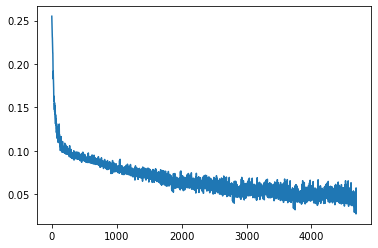

In [257]:
plt.plot(loss_history)
plt.show()

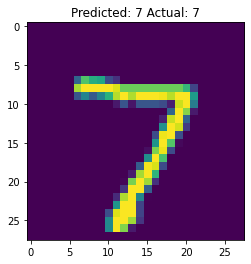

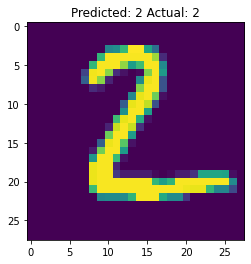

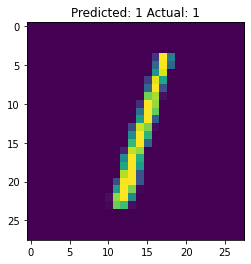

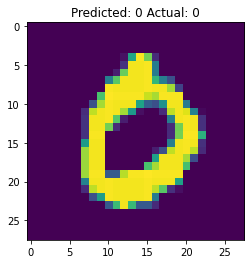

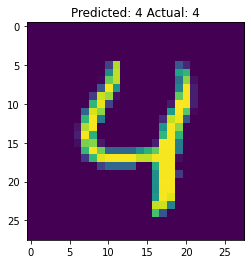

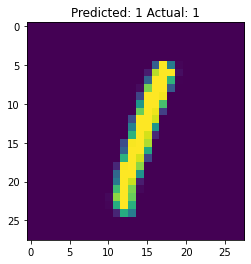

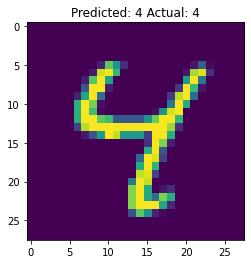

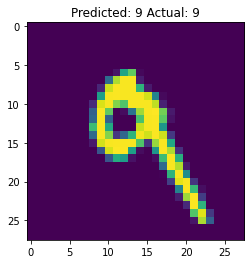

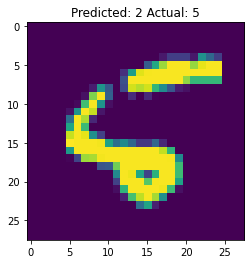

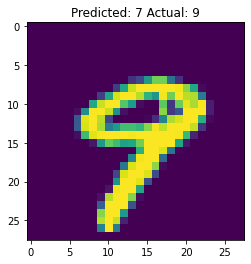

In [258]:
for images, labels in test_data:
  x0 = images.flatten(start_dim=1).numpy()
  x3_pred = activation2(activation1(x0 @ W1.T + b1) @ W2.T + b2)
  pred_labels = np.argmax(x3_pred, axis=1)

  for i in range(10):
    plt.title(f"Predicted: {pred_labels[i]} Actual: {labels[i]}")
    plt.imshow(images[i].reshape(28, 28))
    plt.show()

  break

In [ ]:
ir = 1 # Inference rate
lr = 1e-2 # Learning rate

def get_weights_and_biases(in_features, out_features):
  w = (np.random.random((out_features, in_features)) * 2 - 1) * 1/np.sqrt(in_features)
  b = np.zeros(out_features)

  return w, b

# Define out layer sizes
in_features = 1
out_features = 1

# Define weights and biases
W1, b1 = get_weights_and_biases(in_features, hidden_features)

loss_history = []
activation1 = leaky_relu
activation2 = sigmoid

for epoch in range(1):
  print(f"Epoch {epoch+1}")
    x0 = np.random.choice(2, size=64)[:, None]
    x1 = np.zeros((x0.shape[0], out_features))
    x2 = x0 # Same input as output

    # Run predictive coding inference. 
    for t in range(10):
      u1 = x0 @ W1.T + b1
      u2 = activation1(x1)

      # Calculate errors
      e1 = x1 - u1
      e2 = x2 - u2

      # Canculate derivatives
      dx1 = -e1 + activation1(x1, deriv=True) * (e2 @ W2)
      dx2 = -e2 + activation2(x2, deriv=True) * e3
      #dx3 = -e3 # Only do this during inference

      # Do actual steps
      x1 += ir * dx1
      x2 += ir * dx2
      #x3 -= ir * dx3 # Only do this during inference.

    error_histories = zip(*errors_history)
    for error_history in error_histories:
      plt.plot(error_history)
      plt.show()
      
    # Perform weight update here.
    dW1 = e1[:, :, None] @ activation1(x0)[:, None, :]
    dW2 = e2[:, :, None] @ activation2(x1)[:, None, :]

    W1 += lr * dW1.mean(axis=0)
    W2 += lr * dW2.mean(axis=0)